In [1]:
# IMPORTS AND SETUP
import os
import sys

if os.path.basename(os.getcwd()) == "bughunting":
    os.chdir(os.path.dirname(os.getcwd()))
    sys.path.append(os.getcwd())
import numpy as np
import torch
from lossless.component.coolchic import CoolChicEncoder, CoolChicEncoderParameter
from lossless.configs.config import args
from lossless.training.loss import loss_function
from lossless.training.manager import ImageEncoderManager
from lossless.util.command_line_args_loading import load_args
from lossless.util.image_loading import load_image_as_tensor
from lossless.util.logger import TrainingLogger
from lossless.util.parsecli import change_n_out_synth, get_coolchic_param_from_args
import time
from lossless.training.loss import LossFunctionOutput, loss_function
import itertools
from typing import Optional, OrderedDict, Union
from dataclasses import dataclass, fields
from lossless.component.types import DescriptorNN
from lossless.component.core.arm_image import ImageArm
from lossless.nnquant.expgolomb import measure_expgolomb_rate

torch.autograd.set_detect_anomaly(True)
torch.set_float32_matmul_precision("high")

# ==========================================================================================
# LOAD COMMAND LINE ARGS AND IMAGE
# ==========================================================================================
command_line_args = load_args({"color_space": "YCoCg", "encoder_gain": 64})

im_path = args["input"][command_line_args.image_index]
im_tensor, colorspace_bitdepths = load_image_as_tensor(
    im_path, device="cuda:0", color_space=command_line_args.color_space
)
# ==========================================================================================
# LOAD PRESETS, COOLCHIC PARAMETERS
# ==========================================================================================
image_encoder_manager = ImageEncoderManager(
    preset_name=args["preset"], colorspace_bitdepths=colorspace_bitdepths
)
encoder_param = CoolChicEncoderParameter(**get_coolchic_param_from_args(args, "lossless"))
encoder_param.encoder_gain = command_line_args.encoder_gain
encoder_param.set_image_size((im_tensor.shape[2], im_tensor.shape[3]))
encoder_param.layers_synthesis = change_n_out_synth(
    encoder_param.layers_synthesis, 9 if args["use_color_regression"] else 6
)
encoder_param.use_image_arm = command_line_args.use_image_arm
encoder_param.multi_region_image_arm = args["multi_region_image_arm"]
coolchic = CoolChicEncoder(param=encoder_param)
coolchic.to_device("cuda:0")
# ==========================================================================================
# SETUP LOGGER
# ==========================================================================================
dataset_name = im_path.split("/")[-2]
logger = TrainingLogger(
    log_folder_path=args["LOG_PATH"],
    image_name=f"{dataset_name}_" + im_path.split("/")[-1].split(".")[0],
    debug_mode=image_encoder_manager.n_itr < 1000,
    experiment_name=command_line_args.experiment_name,
    write_to_disk=False,
)
with open(args["network_yaml_path"], "r") as f:
    network_yaml = f.read()
logger.log_result(f"Using image ARM: {command_line_args.use_image_arm}")
logger.log_result(f"Using encoder gain: {command_line_args.encoder_gain}")
logger.log_result(f"Using multi-region image ARM: {args['multi_region_image_arm']}")
logger.log_result(f"Using color regression: {args['use_color_regression']}")
with torch.no_grad():
    logger.log_result(f"Total MAC per pixel: {coolchic.get_total_mac_per_pixel()}")
# ==========================================================================================
# LOAD WEIGHTS
# ==========================================================================================
coolchic.load_state_dict(
    torch.load(
        "../logs/full_runs/2026_01_01_default_name/trained_models/2026_01_01__18_34_25__trained_coolchic_kodak_kodim01_img_rate_3.473954916000366.pth"
    )
)

Converting image to YCoCg color space
Using image ARM: True
Using encoder gain: 64
Using multi-region image ARM: False
Using color regression: False
Total MAC per pixel: 1694.3125


<All keys matched successfully>

In [2]:
# TEST FORWARD PASS WITHOUT QANTIZATION
rate_per_module, total_network_rate = coolchic.get_network_rate()
if command_line_args.use_image_arm:
    arm_params = list(coolchic.image_arm.parameters())
    arm_params_bits = sum(p.numel() for p in arm_params) * 32
    total_network_rate += arm_params_bits
total_network_rate = float(total_network_rate) / im_tensor.numel()

with torch.no_grad():
    # Forward pass with no quantization noise
    predicted_prior = coolchic.forward(
        image=im_tensor,
        quantizer_noise_type="none",
        quantizer_type="hardround",
        AC_MAX_VAL=-1,
        flag_additional_outputs=False,
    )
    predicted_priors_rates = loss_function(
        predicted_prior,
        im_tensor,
        rate_mlp_bpd=total_network_rate,
        colorspace_bitdepths=image_encoder_manager.colorspace_bitdepths,
    )

logger.log_result(
    f"Rate per module: {rate_per_module},\n"
    f"Final results before quantization: {predicted_priors_rates}"
)

Rate per module: {'arm': {'bias': 0.0, 'weight': 0.0}, 'image_arm': {'bias': 0.0, 'weight': 0.0}, 'upsampling': {'bias': 0.0, 'weight': 0.0}, 'synthesis': {'bias': 0.0, 'weight': 0.0}},
Final results before quantization: Loss: 3.467686891555786, Rate NN: 0.021321614583333332, Rate Latent: 0.11398743093013763, Rate Img: 3.3323779106140137


In [3]:
# QUANTIZATION UTILITIES AND DEFINITIONS
# @dataclass
# class DescriptorNN:
#     """Contains information (scale, weight, quantization step, ...) about the
#     weights and biases of a neural network."""

#     weight: Optional[Union[int, float, str, torch.Tensor]] = None
#     bias: Optional[Union[int, float, str, torch.Tensor]] = None

#     def __getitem__(self, item: str) -> Optional[Union[int, float, str, torch.Tensor]]:
#         if item == "weight":
#             return self.weight
#         elif item == "bias":
#             return self.bias
#         return None

#     def __setitem__(self, key: str, value: Union[int, float, str, torch.Tensor]) -> None:
#         if key == "weight":
#             self.weight = value
#         elif key == "bias":
#             self.bias = value


@dataclass
class DescriptorCoolChic:
    """Contains information about the different sub-networks of Cool-chic."""

    arm: Optional[DescriptorNN] = None
    image_arm: Optional[DescriptorNN] = None
    upsampling: Optional[DescriptorNN] = None
    synthesis: Optional[DescriptorNN] = None


POSSIBLE_EXP_GOL_COUNT = {
    "arm": {
        "weight": torch.linspace(0, 12, 13, device="cpu"),
        "bias": torch.linspace(0, 12, 13, device="cpu"),
    },
    "image_arm": {
        "weight": torch.linspace(0, 12, 13, device="cpu"),
        "bias": torch.linspace(0, 12, 13, device="cpu"),
    },
    "upsampling": {
        "weight": torch.linspace(0, 12, 13, device="cpu"),
        "bias": torch.linspace(0, 12, 13, device="cpu"),
    },
    "synthesis": {
        "weight": torch.linspace(0, 12, 13, device="cpu"),
        "bias": torch.linspace(0, 12, 13, device="cpu"),
    },
}


def exp_golomb_nbins(symbol: torch.Tensor, count: int = 0) -> torch.Tensor:
    """Compute the number of bits required to encode a Tensor of integers
    using an exponential-golomb code with exponent ``count``.

    Args:
        symbol: Tensor to encode
        count (int, optional): Exponent of the exp-golomb code. Defaults to 0.

    Returns:
        Number of bits required to encode all the symbols.
    """

    # We encode the sign equiprobably at the end thus one more bit if symbol != 0
    nbins = 2 * torch.floor(torch.log2(symbol.abs() / (2**count) + 1)) + count + 1 + (symbol != 0)
    res = nbins.sum()
    return res


POSSIBLE_Q_STEP_SHIFT = {
    "arm": {
        "weight": torch.linspace(-8, 0, 9, device="cpu"),
        "bias": torch.linspace(-16, 0, 17, device="cpu"),
    },
    "image_arm": {
        "weight": torch.linspace(-8, 0, 9, device="cpu"),
        "bias": torch.linspace(-16, 0, 17, device="cpu"),
    },
}


POSSIBLE_Q_STEP = {
    "arm": {
        "weight": 2.0 ** POSSIBLE_Q_STEP_SHIFT["arm"]["weight"],
        "bias": 2.0 ** POSSIBLE_Q_STEP_SHIFT["arm"]["bias"],
    },
    "image_arm": {
        "weight": 2.0 ** torch.linspace(-12, 0, 13, device="cpu"),
        "bias": 2.0 ** torch.linspace(-24, 0, 25, device="cpu"),
    },
    "upsampling": {
        "weight": 2.0 ** torch.linspace(-12, 0, 13, device="cpu"),
        "bias": 2.0 ** torch.tensor([0.0]),
    },
    "synthesis": {
        "weight": 2.0 ** torch.linspace(-12, 0, 13, device="cpu"),
        "bias": 2.0 ** torch.linspace(-24, 0, 25, device="cpu"),
    },
}


def get_q_step_from_parameter_name(parameter_name: str, q_step: DescriptorNN) -> Optional[torch.Tensor]:
    """Return the specific quantization step from q_step (a dictionary
    with several quantization steps). The specific quantization step is
    selected through the parameter name.

    Args:
        parameter_name (str): Name of the parameter in the state dict.
        q_step (DescriptorNN): Dictionary gathering several quantization
            steps. E.g. one quantization step for the weights and one for
            the biases.

    Returns:
        Optional[float]: The quantization step associated to the parameter.
            Return None if nothing is found.
    """
    if ".weight" in parameter_name:
        current_q_step = q_step["weight"]
    elif ".bias" in parameter_name:
        current_q_step = q_step["bias"]
    else:
        print('Parameter name should include ".weight" or ".bias" ' f"Found: {parameter_name}")
        current_q_step = None
        return current_q_step
    
    # print(type(current_q_step))
    # assert type(current_q_step) is float
    return current_q_step


def _quantize_parameters(
    fp_param: OrderedDict[str, torch.Tensor],
    q_step: DescriptorNN,
) -> Optional[OrderedDict[str, torch.Tensor]]:
    MAX_AC_MAX_VAL = 65535  # 2**16 for 16-bit code in bitstream header.

    q_param = OrderedDict()
    for k, v in fp_param.items():
        current_q_step = get_q_step_from_parameter_name(k, q_step)
        # supress type warning
        assert current_q_step is not None
        sent_param = torch.round(v / current_q_step)

        if sent_param.abs().max() > MAX_AC_MAX_VAL:
            return None

        q_param[k] = sent_param * current_q_step

    return q_param


In [4]:
# @dataclass
# class DescriptorCoolChic:
#     """Contains information about the different sub-networks of Cool-chic."""

#     # arm: Optional[DescriptorNN] = None
#     image_arm: Optional[DescriptorNN] = None
#     # upsampling: Optional[DescriptorNN] = None
#     # synthesis: Optional[DescriptorNN] = None


In [5]:
from typing import TypeGuard

def is_dict_str_tensor(d: dict) -> TypeGuard[OrderedDict[str, torch.Tensor]]:
    """Type guard to check if a dictionary has str keys and torch.Tensor values."""
    return all(isinstance(k, str) and isinstance(v, torch.Tensor) for k, v in d.items())

@torch.no_grad()
def quantize_model(
    model: CoolChicEncoder,
    image: torch.Tensor,
    image_encoder_manager: ImageEncoderManager,
) -> CoolChicEncoder:
    start_time = time.time()
    model.eval()
    assert isinstance(model.image_arm, ImageArm)
    module_name = "image_arm"
    cur_module = model.image_arm

    print(f"\nQuantizing module: {module_name}")
    print(f"Current module: {cur_module}")
    best_loss = LossFunctionOutput(
        loss=torch.Tensor([1e6]).to(image.device),
        rate_nn_bpd=0.0,
        rate_latent_bpd=0.0,
        rate_img_bpd=1e6,
    )

    all_q_step = POSSIBLE_Q_STEP[module_name]
    all_expgol_cnt = POSSIBLE_EXP_GOL_COUNT[module_name]

    full_precision_param = cur_module.get_param()
    assert is_dict_str_tensor(full_precision_param), "full_precision_param has wrong type"

    best_q_step: DescriptorNN = DescriptorNN()
    # Overall best expgol count for this module weights and biases
    final_best_expgol_cnt = DescriptorNN()
    all_q_step_weight = all_q_step["weight"]
    all_q_step_bias = all_q_step["bias"]

    for q_step_w, q_step_b in itertools.product(all_q_step_weight, all_q_step_bias):
        current_q_step: DescriptorNN = DescriptorNN(
            weight=q_step_w,
            bias=q_step_b,
        )
        q_param = _quantize_parameters(full_precision_param, current_q_step)

        # Quantization has failed
        if q_param is None:
            continue

        cur_module.set_param(q_param)
        setattr(model, module_name, cur_module)
        model.nn_q_step[module_name] = current_q_step

        # Test Cool-chic performance with this quantization steps pair
        frame_encoder_out = model.forward(
            image=image,
            quantizer_noise_type="none",
            quantizer_type="hardround",
            AC_MAX_VAL=-1,
            flag_additional_outputs=False,
        )

        param = cur_module.get_param()

        # Best exp-golomb count for this quantization step
        best_expgol_cnt = DescriptorNN()
        for weight_or_bias in ["weight", "bias"]:

            # Find the best exp-golomb count for this quantization step:
            cur_best_expgol_cnt = None
            # Arbitrarily high number
            cur_best_rate = 1e9

            sent_param = []
            for parameter_name, parameter_value in param.items():

                # Quantization is round(parameter_value / q_step) * q_step so we divide by q_step
                # to obtain the sent latent.
                current_sent_param = (parameter_value / current_q_step[weight_or_bias]).view(-1)

                if weight_or_bias in parameter_name:
                    sent_param.append(current_sent_param)

            # Integer, sent parameters
            v = torch.cat(sent_param)

            # Find the best expgol count for this weight
            for expgol_cnt in all_expgol_cnt[weight_or_bias]:
                cur_rate = exp_golomb_nbins(v, count=int(expgol_cnt))
                if cur_rate < cur_best_rate:
                    cur_best_rate = cur_rate
                    cur_best_expgol_cnt = expgol_cnt

            assert cur_best_expgol_cnt is not None
            best_expgol_cnt[weight_or_bias] = cur_best_expgol_cnt

        model.nn_expgol_cnt[module_name] = best_expgol_cnt

        _, total_rate_nn_bit = model.get_network_rate()

        loss_fn_output = loss_function(
            frame_encoder_out,
            image,
            rate_mlp_bpd=total_rate_nn_bit / image.numel(),
            latent_multiplier=1.0,
            colorspace_bitdepths=image_encoder_manager.colorspace_bitdepths,
        )

        # Store best quantization steps
        if loss_fn_output.loss < best_loss.loss:
            best_loss = loss_fn_output
            best_q_step = current_q_step
            final_best_expgol_cnt = best_expgol_cnt
            if module_name == "image_arm":
                print(
                    loss_fn_output.loss.cpu().item(),
                    q_step_w.cpu().item(),
                    q_step_b.cpu().item(),
                )

    # Once we've tested all the possible quantization step and expgol_cnt,
    # quantize one last time with the best one we've found to actually use it.
    model.nn_q_step[module_name] = best_q_step
    model.nn_expgol_cnt[module_name] = final_best_expgol_cnt

    q_param = _quantize_parameters(full_precision_param, model.nn_q_step[module_name])
    assert q_param is not None, (
        "_quantize_parameters() failed with q_step " f"{model.nn_q_step[module_name]}"
    )
    print(f"Best loss for module {module_name}: {best_loss}")

    cur_module.set_param(q_param)
    # Plug the quantized module back into Cool-chic
    setattr(model, module_name, cur_module)

    time_nn_quantization = time.time() - start_time

    print(f"\nTime quantize_model(): {time_nn_quantization:4.1f} seconds\n")
    # if image_encoder_manager is not None:
    #     image_encoder_manager.total_training_time_sec += time_nn_quantization

    return model

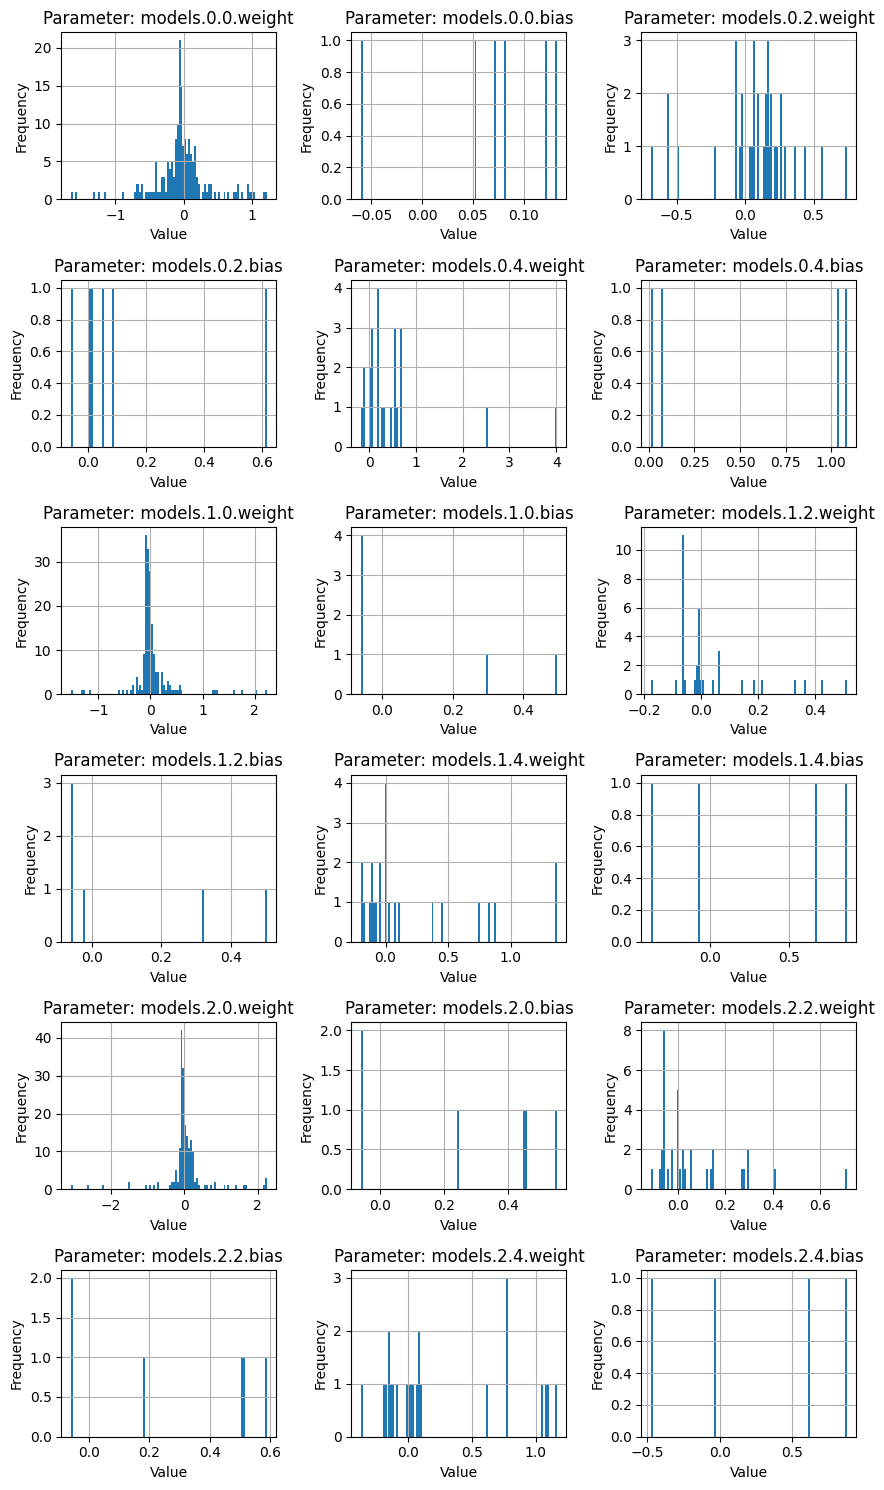

In [6]:
# Visualization of image arm parameters
def visualize_image_arm_params(model: CoolChicEncoder):
    import matplotlib.pyplot as plt
    image_arm = model.image_arm
    if image_arm is None:
        print("No image arm to visualize.")
        return
    
    fig, axs = plt.subplots(6, 3, figsize=(9, 15))
    for idx, (name, param) in enumerate(image_arm.named_parameters()):
        param_data = param.detach().cpu().numpy()
        
        axs[idx // 3, idx % 3].set_title(f"Parameter: {name}")
        axs[idx // 3, idx % 3].hist(param_data.flatten(), bins=100)
        axs[idx // 3, idx % 3].set_xlabel("Value")
        axs[idx // 3, idx % 3].set_ylabel("Frequency")
        axs[idx // 3, idx % 3].grid()
    plt.tight_layout()
    plt.show()

visualize_image_arm_params(coolchic)

In [7]:
quantized_model: CoolChicEncoder = CoolChicEncoder(param=encoder_param)
quantized_model.load_state_dict(coolchic.state_dict())
quantized_model.to_device("cuda:0")
assert isinstance(quantized_model.image_arm, ImageArm)

quantized_model = quantize_model(
    model=quantized_model,
    image=im_tensor,
    image_encoder_manager=image_encoder_manager,
)

def image_arm_rate(model: CoolChicEncoder) -> tuple[dict[str, dict[str, float]], float]:

    rate_per_module: dict[str, dict[str, float]] = {
        "image_arm": {"weight": 0.0, "bias": 0.0}
    }

    total_rate = 0.0
    cur_module = model.image_arm
    rate_per_module["image_arm"] = measure_expgolomb_rate(
        cur_module,
        model.nn_q_step["image_arm"],
        model.nn_expgol_cnt["image_arm"],
    )

    total_rate += sum(rate_per_module["image_arm"].values())

    return rate_per_module, total_rate

# rate_per_module, total_network_rate = quantized_model.get_network_rate()
rate_per_module, total_network_rate = image_arm_rate(quantized_model)
total_network_rate = float(total_network_rate) / im_tensor.numel()

with torch.no_grad():
    # Forward pass with no quantization noise
    predicted_prior = quantized_model.forward(
        image=im_tensor,
        quantizer_noise_type="none",
        quantizer_type="hardround",
        AC_MAX_VAL=-1,
        flag_additional_outputs=False,
    )
    predicted_priors_rates = loss_function(
        predicted_prior,
        im_tensor,
        rate_mlp_bpd=total_network_rate,
        colorspace_bitdepths=colorspace_bitdepths,
    )

logger.log_result(
    f"Rate per module: {rate_per_module},\n"
    f"Final results before quantization: {predicted_priors_rates}"
)


Quantizing module: image_arm
Current module: ImageArm(
  (models): ModuleList(
    (0-2): 3 x Sequential(
      (0): ArmLinear()
      (1): ReLU()
      (2): ArmLinear()
      (3): ReLU()
      (4): ArmLinear()
    )
  )
)
3.4549341201782227 0.000244140625 3.0517578125e-05
3.4549005031585693 0.000244140625 6.103515625e-05
3.4548721313476562 0.000244140625 0.0001220703125
3.4547932147979736 0.000244140625 0.000244140625
3.4546971321105957 0.000244140625 0.0009765625
3.4546799659729004 0.00048828125 0.00048828125
3.453317165374756 0.001953125 3.0517578125e-05
3.4532737731933594 0.001953125 6.103515625e-05
3.4532365798950195 0.001953125 0.0001220703125
3.4531710147857666 0.001953125 0.000244140625
3.452889919281006 0.001953125 0.0009765625
Best loss for module image_arm: Loss: 3.452889919281006, Rate NN: 0.0062705148011446, Rate Latent: 0.11398743093013763, Rate Img: 3.332632064819336

Time quantize_model(): 10.2 seconds

Rate per module: {'image_arm': {'bias': tensor(514., device='cuda: